# LSTM + Vietnamese Embedding Multimodal Stock Prediction

**Architecture:**
- **Text Encoder**: https://huggingface.co/AITeamVN/Vietnamese_Embedding - encode news text
- **Time Series Encoder**: LSTM - encode price/volume features
- **Fusion**: Concatenate embeddings from both encoders or use Cross Attention (query=lstm_out, key=value=text)
- **Decoder**: Fully Connected layers - predict multiple horizons

**Text Selection Logic:**
- Use news from the most recent 3 days (H, H-1, H-2) instead of only one day

- Apply average pooling per day to aggregate multiple news articles published on the same day

- Use sinusoidal positional encoding to preserve the temporal order of the three days

# Install and Import Libraries

In [ ]:
!pip install -q torch transformers sentence-transformers

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import timedelta

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')

import pickle

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Vietnamese Embedding Model

In [ ]:
MODEL_NAME = "AITeamVN/Vietnamese_Embedding"

print(f"Loading {MODEL_NAME}...")
embedding_model = SentenceTransformer(MODEL_NAME)
embedding_model = embedding_model.to(device)
embedding_model.eval()

EMBEDDING_DIM = embedding_model.get_sentence_embedding_dimension()
print(f"Model loaded successfully!")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Loading AITeamVN/Vietnamese_Embedding...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Model loaded successfully!
Embedding dimension: 1024


In [ ]:
# Freeze model parameters (optional - can unfreeze for fine-tuning)
FREEZE_MODEL = True

if FREEZE_MODEL:
    for param in embedding_model.parameters():
        param.requires_grad = False
    print("Embedding model parameters frozen")
else:
    print("Embedding model parameters unfrozen - will be fine-tuned")

Embedding model parameters frozen


# Load Datasets

In [ ]:
# Load news data
news_df = pd.read_csv("merged_kaggle_collected_news.csv")
news_df['date'] = pd.to_datetime(news_df['date'])

# Sort by date
news_df = news_df.sort_values('date').reset_index(drop=True)

print(f"News data shape: {news_df.shape}")
print(f"Date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"\nColumns: {news_df.columns.tolist()}")

News data shape: (13739, 5)
Date range: 2019-12-16 00:00:00 to 2025-10-20 00:00:00

Columns: ['date', 'content', 'content_clean', 'title', 'url']


In [ ]:
news_df

,date,content,content_clean,title,url
0,2019-12-16,“Thương hiệu dẫn đầu Việt Nam – Vietnam Leadin...,Thương hiệu dẫn đầu Việt Nam Vietnam Leading B...,BVSC nhận “Top 10 thương hiệu dẫn đầu Việt Nam...,https://baodautu.vn/bvsc-nhan-top-10-thuong-hi...
1,2019-12-16,"Tính đến hết tháng 11/2019, vốn hóa thị trườn...","Tính đến hết tháng 11/2019, vốn hóa thị trường...","Thị trường chứng khoán: Thanh khoản muốn tăng,...",https://baodautu.vn/thi-truong-chung-khoan-tha...
2,2019-12-17,Vàng miếng SJC tại Vàng bạc Đá quý Sài Gòn tiế...,Vàng miếng SJC tại Vàng bạc Đá quý Sài Gòn tiế...,"Giá vàng 14/12 tiếp tục tăng, đồng bảng Anh lậ...",https://baodautu.vn/gia-vang-1412-tiep-tuc-tan...
3,2019-12-20,Lệnh vào nhấp nháy liên tục trên bảng điện tại...,Lệnh vào nhấp nháy liên tục trên bảng điện tại...,Thị trường chứng khoán: Trăn trở khi penny dậy...,https://baodautu.vn/thi-truong-chung-khoan-tra...
4,2019-12-23,Chứng khoán Trung Quốc đại lục mở phiên khá ảm...,Chứng khoán Trung Quốc đại lục mở phiên khá ảm...,Chứng khoán Trung Quốc vẫn yên ắng sau tin cắt...,https://baodautu.vn/chung-khoan-trung-quoc-van...
...,...,...,...,...,...
13734,2025-10-18,"Giá vàng tuần qua biến động mạnh, liên tục phá...","Giá vàng tuần qua biến động mạnh, liên tục phá...",Nhìn lại tuần bùng nổ của giá vàng,https://laodong.vn/tien-te-dau-tu/nhin-lai-tua...
13735,2025-10-19,"Giá vàng SJC giảm 0,47%. Giá vàng thế giới giả...","Giá vàng SJC giảm 0,47%. Giá vàng thế giới giả...",Giá vàng SJC giảm theo thế giới,https://vneconomy.vn/gia-vang-sjc-giam-theo-th...
13736,2025-10-19,Giá vàng thế giới chốt tuần ở mức cao chót vót...,Giá vàng thế giới chốt tuần ở mức cao chót vót...,"Trải qua tuần tăng ""nóng"", các chuyên gia vẫn ...",https://nhandan.vn/trai-qua-tuan-tang-nong-cac...
13737,2025-10-20,ACB công bố kết quả kinh doanh quý 3 với lợi n...,ACB công bố kết quả kinh doanh quý 3 với lợi n...,Quý 3/2025: ACB duy trì tăng trưởng ổn định nă...,https://vneconomy.vn/quy-32025-acb-duy-tri-tan...


In [ ]:
# Check news per day distribution
news_per_day = news_df.groupby('date').size()
print(f"\nNews statistics:")
print(f"  Total unique dates with news: {len(news_per_day)}")
print(f"  Mean news per day: {news_per_day.mean():.2f}")
print(f"  Max news per day: {news_per_day.max()}")
print(f"  Min news per day: {news_per_day.min()}")


News statistics:
  Total unique dates with news: 2130
  Mean news per day: 6.45
  Max news per day: 24
  Min news per day: 1


In [ ]:
# Group news by date - keep as list of articles per date
news_by_date = news_df.groupby('date')['content_clean'].apply(list).to_dict()

print(f"Created news lookup for {len(news_by_date)} dates")
print(f"Sample dates: {list(news_by_date.keys())[:3]}")
print(f"Sample article count per date: {[len(news_by_date[d]) for d in list(news_by_date.keys())[:3]]}")

Created news lookup for 2130 dates
Sample dates: [Timestamp('2019-12-16 00:00:00'), Timestamp('2019-12-17 00:00:00'), Timestamp('2019-12-20 00:00:00')]
Sample article count per date: [2, 1, 1]


In [ ]:
# Load stock price data
dataset = pd.read_csv("dataset_ACB_fullFeatures.csv")

In [ ]:
dataset.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'field',
       'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL',
       'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14',
       'GDP × 10^9 (USD)', 'CPI', 'usd_vnd'],
      dtype='object')

In [ ]:
dataset.drop(columns=['field','ticker'], inplace=True)
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

print(f"Stock data shape: {dataset.shape}")
print(f"Date range: {dataset.index.min()} to {dataset.index.max()}")

Stock data shape: (1442, 19)
Date range: 2020-01-02 00:00:00 to 2025-10-20 00:00:00


In [ ]:
numeric_vars = ['open', 'high', 'low','close','volume','RSI_14',
                'MA_10', 'MA_50', 'MA_200','MACD','MACD_SIGNAL','MACD_HIST',
                'ADX_14','STOCH_K','STOCH_D',
                'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
for var in numeric_vars:
    dataset[var] = pd.to_numeric(dataset[var], errors='coerce')

In [ ]:
dataset.shape, dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2020-01-02 to 2025-10-20
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              1442 non-null   float64
 1   high              1442 non-null   float64
 2   low               1442 non-null   float64
 3   close             1442 non-null   float64
 4   volume            1442 non-null   float64
 5   RSI_14            1442 non-null   float64
 6   MA_10             1442 non-null   float64
 7   MA_50             1442 non-null   float64
 8   MA_200            1442 non-null   float64
 9   MACD              1442 non-null   float64
 10  MACD_SIGNAL       1442 non-null   float64
 11  MACD_HIST         1442 non-null   float64
 12  ADX_14            1442 non-null   float64
 13  STOCH_K           1442 non-null   float64
 14  STOCH_D           1442 non-null   float64
 15  STOCHRSI_14       1442 non-null   float64
 16  GDP × 10^9 (USD)  1442 n

((1442, 19), None)

# Prepare Data (Splitting and Scaling)

In [ ]:
data = dataset.copy()

# Lưu data gốc TRƯỚC KHI SCALE
data_original = data.copy()

train_ratio = 0.6
valid_ratio = 0.15

n = len(data)
train_end = int(train_ratio * n)
valid_end = int((train_ratio + valid_ratio) * n)

train_df = data.iloc[:train_end].copy()
valid_df = data.iloc[train_end:valid_end].copy()
test_df  = data.iloc[valid_end:].copy()

# Data gốc cho evaluation
train_df_original = data_original.iloc[:train_end].copy()
valid_df_original = data_original.iloc[train_end:valid_end].copy()
test_df_original  = data_original.iloc[valid_end:].copy()

print(f"Total: {n}")
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Total: 1442
Train: 865, Valid: 216, Test: 361


In [ ]:
# Features dùng RobustScaler (KHÔNG bao gồm close)
features_robust = ['open', 'high', 'low','volume','RSI_14',
                'MA_10', 'MA_50', 'MA_200','MACD','MACD_SIGNAL','MACD_HIST',
                'ADX_14','STOCH_K','STOCH_D','STOCHRSI_14',
                'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']

# RobustScaler cho các features khác
scaler_robust = RobustScaler().fit(train_df[features_robust])

train_df[features_robust] = scaler_robust.transform(train_df[features_robust])
valid_df[features_robust] = scaler_robust.transform(valid_df[features_robust])
test_df[features_robust]  = scaler_robust.transform(test_df[features_robust])

#StandardScaler cho close
scaler_close = StandardScaler().fit(train_df[['close']])

train_df['close'] = scaler_close.transform(train_df[['close']])
valid_df['close'] = scaler_close.transform(valid_df[['close']])
test_df['close']  = scaler_close.transform(test_df[['close']])

print(f"\nScaling summary:")
print(f"  RobustScaler: {features_robust}")
print(f"  StandardScaler: ['close']")


Scaling summary:
  RobustScaler: ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
  StandardScaler: ['close']


# Pre-encode Text with Vietnamese Embedding

In [ ]:
def encode_text(text, model, device):
    """
    Encode a single text using SentenceTransformer.
    Returns the sentence embedding.
    """
    if not text or len(str(text).strip()) == 0:
        return torch.zeros(EMBEDDING_DIM)

    with torch.no_grad():
        embedding = model.encode(
            text,
            convert_to_tensor=True,
            device=device
        )

    return embedding.cpu()

In [ ]:
def encode_articles_with_average_pool(articles_list, model, device):
    """
    Encode multiple articles and return their average embedding.

    Args:
        articles_list: List of article texts for a single day
        model: SentenceTransformer model
        device: cuda/cpu

    Returns:
        Average embedding tensor (EMBEDDING_DIM,)
    """
    if not articles_list or len(articles_list) == 0:
        return torch.zeros(EMBEDDING_DIM)

    # Filter out empty articles
    valid_articles = [a for a in articles_list if a and len(str(a).strip()) > 0]

    if len(valid_articles) == 0:
        return torch.zeros(EMBEDDING_DIM)

    with torch.no_grad():
        # Encode all articles at once (more efficient)
        embeddings = model.encode(
            valid_articles,
            convert_to_tensor=True,
            device=device,
            batch_size=32
        )

        # Average pooling
        avg_embedding = embeddings.mean(dim=0)

    return avg_embedding.cpu()

In [ ]:
# Test encoding
test_text = "Thị trường chứng khoán Việt Nam tăng mạnh trong phiên giao dịch hôm nay."
test_embedding = encode_text(test_text, embedding_model, device)
print(f"Test embedding shape: {test_embedding.shape}")
print(test_embedding)

Test embedding shape: torch.Size([1024])
tensor([0.0120, 0.0814, 0.0082,  ..., 0.0377, 0.0186, 0.0193])


In [ ]:
# Pre-encode all dates - using AVERAGE POOLING for multiple articles per day
print(f"Pre-encoding all news with average pooling using {MODEL_NAME}...")

text_embeddings_cache = {}

for i, (date, articles_list) in enumerate(news_by_date.items()):
    # Average pool all articles for this day
    avg_embedding = encode_articles_with_average_pool(articles_list, embedding_model, device)
    text_embeddings_cache[date] = avg_embedding

    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(news_by_date)} dates")

print(f"\nPre-encoded {len(text_embeddings_cache)} date embeddings (with average pooling)")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Pre-encoding all news with average pooling using AITeamVN/Vietnamese_Embedding...
  Processed 200/2130 dates
  Processed 400/2130 dates
  Processed 600/2130 dates
  Processed 800/2130 dates
  Processed 1000/2130 dates
  Processed 1200/2130 dates
  Processed 1400/2130 dates
  Processed 1600/2130 dates
  Processed 1800/2130 dates
  Processed 2000/2130 dates

Pre-encoded 2130 date embeddings (with average pooling)
Embedding dimension: 1024


In [ ]:
# Save cache sau khi encode xong
with open('text_embeddings_cache.pkl', 'wb') as f:
    pickle.dump(text_embeddings_cache, f)

In [ ]:
# Load lại lần sau (chỉ vài giây)
with open('text_embeddings_cache.pkl', 'rb') as f:
    text_embeddings_cache = pickle.load(f)

#Sinusoidal Positional Encoding

In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal Positional Encoding for temporal awareness.

    Cho phép model phân biệt tin tức ngày H (gần nhất), H-1, H-2 (xa hơn).

    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=10):
        super(SinusoidalPositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not a parameter, but saved with model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
            x + positional encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)

# Dataset Class with multi-day news

In [ ]:
# Configuration for multi-day news
NEWS_LOOKBACK_DAYS = 3  # Use news from H, H-1, H-2

print(f"News lookback: {NEWS_LOOKBACK_DAYS} days")
print(f"For predicting H+1, H+4, ... will use news from days: H, H-1, H-2")

News lookback: 3 days
For predicting H+1, H+4, ... will use news from days: H, H-1, H-2


In [ ]:
def get_multiday_news_embeddings(target_date, news_by_date, text_embeddings_cache,
                                  num_days=3, embedding_dim=768, max_search_days=30):
    """
    Get news embeddings for multiple days (H, H-1, H-2, ...).

    Args:
        target_date: The base date (H) - last day in window
        news_by_date: Dict {date: [list of articles]}
        text_embeddings_cache: Dict {date: embedding tensor}
        num_days: Number of days to look back (default 3)
        embedding_dim: Dimension of embeddings
        max_search_days: Max days to search if no news on exact date

    Returns:
        Tensor of shape (num_days, embedding_dim)
        - Index 0: Ngày H (gần nhất)
        - Index 1: Ngày H-1
        - Index 2: Ngày H-2
    """
    if not isinstance(target_date, pd.Timestamp):
        target_date = pd.Timestamp(target_date)

    embeddings = []

    for day_offset in range(num_days):  # 0, 1, 2 -> H, H-1, H-2
        check_date = target_date - timedelta(days=day_offset)

        # Try to find news for this date (or nearest available)
        found_embedding = None
        for search_offset in range(max_search_days + 1):
            search_date = check_date - timedelta(days=search_offset)
            if search_date in text_embeddings_cache:
                found_embedding = text_embeddings_cache[search_date]
                break

        if found_embedding is None:
            found_embedding = torch.zeros(embedding_dim)

        embeddings.append(found_embedding)

    # Stack to (num_days, embedding_dim)
    return torch.stack(embeddings, dim=0)

In [ ]:
class StockMultiDayNewsDataset(Dataset):
    """
    Dataset that combines time series features with MULTI-DAY news embeddings.

    Thay đổi chính:
    - text_emb có shape (num_news_days, embedding_dim) thay vì (embedding_dim,)
    - Cho phép model học từ tin tức nhiều ngày
    """
    def __init__(self, df, df_original, feature_cols,
                 news_by_date, text_embeddings_cache,
                 horizons=[1, 4, 8, 12, 24], window=36,
                 embedding_dim=768, num_news_days=3, max_lookback_days=30):
        """
        Args:
            df: DataFrame đã được scale
            df_original: DataFrame GỐC (chưa scale) để lấy giá thực
            feature_cols: Các cột feature
            news_by_date: Dict {date: [list of articles]}
            text_embeddings_cache: Dict {date: embedding tensor}
            horizons: Các horizon cần dự đoán [1, 4, 8, 12, 24]
            window: Số ngày lookback (L)
            embedding_dim: Dimension of text embeddings
            num_news_days: Số ngày tin tức sử dụng (default 3: H, H-1, H-2)
            max_lookback_days: Max days to look back for news
        """
        self.samples = []
        self.horizons = horizons
        self.embedding_dim = embedding_dim
        self.num_news_days = num_news_days

        features = df[feature_cols].values
        close_original = df_original['close'].values
        dates = df.index

        n = len(df)
        for i in range(n - window - max(horizons)):
            # Time series features for window
            X = features[i : i + window]

            # Get the last date in the window (day H)
            last_date_in_window = dates[i + window - 1]

            # Get MULTI-DAY news embeddings (H, H-1, H-2)
            text_emb = get_multiday_news_embeddings(
                last_date_in_window,
                news_by_date,
                text_embeddings_cache,
                num_days=num_news_days,
                embedding_dim=embedding_dim,
                max_search_days=max_lookback_days
            )

            # Base price GỐC (ngày cuối window)
            base_price = close_original[i + window - 1]

            # Target: cumulative pct_change từ ngày H đến ngày H+h
            y = []
            actual_prices = []
            for h in horizons:
                future_price = close_original[i + window - 1 + h]
                cumulative_return = (future_price - base_price) / base_price
                y.append(cumulative_return)
                actual_prices.append(future_price)

            self.samples.append((
                torch.tensor(X, dtype=torch.float32),
                text_emb,  # Shape: (num_news_days, embedding_dim)
                torch.tensor(y, dtype=torch.float32),
                base_price,
                torch.tensor(actual_prices, dtype=torch.float32)
            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Multimodal Model: LSTM + Vietnamese Embedding

## Fusion: concatenate (torch.cat)

In [ ]:
# Alternative: Concat model (không dùng attention)
class LSTMConcatMultiDayNews(nn.Module):
    """
    LSTM + Concat model với Multi-Day News (baseline so sánh).

    Thay vì Cross-Attention, chỉ đơn giản:
    - Average pool news embeddings từ 3 ngày
    - Concat với LSTM output
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2,
                 num_horizons=5, dropout=0.3,
                 embedding_dim=768, num_news_days=3,
                 text_proj_dim=64, use_text=True):
        super(LSTMConcatMultiDayNews, self).__init__()

        self.use_text = use_text
        self.hidden_dim = hidden_dim
        self.num_news_days = num_news_days

        # LSTM Encoder
        self.lstm_encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        if use_text:
            # Positional Encoding
            self.positional_encoding = SinusoidalPositionalEncoding(
                d_model=embedding_dim,
                max_len=num_news_days + 5
            )

            # Text projection (after average pooling)
            self.text_projection = nn.Sequential(
                nn.Linear(embedding_dim, text_proj_dim * 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(text_proj_dim * 2, text_proj_dim),
                nn.ReLU()
            )

            fusion_dim = hidden_dim + text_proj_dim
        else:
            fusion_dim = hidden_dim

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim // 2, num_horizons)
        )

    def forward(self, x_ts, x_text=None):
        # Encode time series
        lstm_out, (hidden, cell) = self.lstm_encoder(x_ts)
        ts_embedding = hidden[-1]

        if self.use_text and x_text is not None:
            # Add positional encoding
            news_with_pos = self.positional_encoding(x_text)

            # Average pool across days
            news_avg = news_with_pos.mean(dim=1)  # (batch, embedding_dim)

            # Project
            text_proj = self.text_projection(news_avg)  # (batch, text_proj_dim)

            # Concat
            fused = torch.cat([ts_embedding, text_proj], dim=-1)
        else:
            fused = ts_embedding

        predictions = self.decoder(fused)
        return predictions, None

##Cross attention

**Model Architecture**

**Cross-Attention Flow:**
```
Query  = LSTM output (market representation)
Key    = Multi-day news (with positional encoding)
Value  = Multi-day news (with positional encoding)

→ Market "hỏi" tin tức: "Tin nào liên quan đến biến động giá?"
→ Attention weights cho biết độ quan trọng của từng ngày tin tức
```

In [ ]:
class LSTMCrossAttentionMultiDayNews(nn.Module):
    """
    LSTM + Cross-Attention model với Multi-Day News Integration.

    Pipeline:
    1. News Encoder:
       - Input: Multi-day news embeddings (batch, num_days, embedding_dim)
       - Add Positional Encoding
       - Project to hidden_dim via FFN

    2. Time-Series Encoder:
       - LSTM encodes historical price data
       - Output: lstm_out (batch, seq_len, hidden_dim)

    3. Cross-Attention:
       - Query = LSTM output (market asks)
       - Key = Value = News embeddings (market queries news)
       - Giúp market tìm tin tức liên quan

    4. Fusion & Prediction:
       - Concatenate [ts_embedding, cross_attn_output]
       - MLP decoder for multi-horizon prediction
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2,
                 num_horizons=5, dropout=0.3,
                 embedding_dim=768, num_news_days=3,
                 num_attention_heads=4, use_text=True):
        super(LSTMCrossAttentionMultiDayNews, self).__init__()

        self.use_text = use_text
        self.hidden_dim = hidden_dim
        self.num_news_days = num_news_days

        # ===== Time Series Encoder (LSTM) =====
        self.lstm_encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        if use_text:
            # ===== News Encoder =====
            # 1. Positional Encoding cho multi-day news
            self.positional_encoding = SinusoidalPositionalEncoding(
                d_model=embedding_dim,
                max_len=num_news_days + 5  # Buffer thêm
            )

            # 2. FFN để project news embeddings về hidden_dim
            self.news_ffn = nn.Sequential(
                nn.Linear(embedding_dim, hidden_dim * 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU()
            )

            # ===== Cross-Attention =====
            # Query = LSTM output, Key = Value = News
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=hidden_dim,
                num_heads=num_attention_heads,
                dropout=dropout,
                batch_first=True
            )

            # Layer norm after attention
            self.attn_layer_norm = nn.LayerNorm(hidden_dim)

            fusion_dim = hidden_dim * 2  # ts_embedding + cross_attn_output
        else:
            fusion_dim = hidden_dim

        # ===== Decoder =====
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim // 2, num_horizons)
        )

    def forward(self, x_ts, x_text=None):
        """
        Args:
            x_ts: Time series input (batch, seq_len, input_dim)
            x_text: Multi-day news embeddings (batch, num_news_days, embedding_dim)

        Returns:
            predictions: (batch, num_horizons)
            attention_weights: (batch, seq_len, num_news_days) - for visualization
        """
        batch_size = x_ts.size(0)

        # ===== Encode Time Series =====
        lstm_out, (hidden, cell) = self.lstm_encoder(x_ts)
        # lstm_out: (batch, seq_len, hidden_dim)
        # hidden[-1]: (batch, hidden_dim) - last layer hidden state

        ts_embedding = hidden[-1]  # (batch, hidden_dim)

        attention_weights = None

        if self.use_text and x_text is not None:
            # ===== Encode News =====
            # 1. Add Positional Encoding
            # x_text: (batch, num_news_days, embedding_dim)
            news_with_pos = self.positional_encoding(x_text)

            # 2. Project to hidden_dim via FFN
            # news_proj: (batch, num_news_days, hidden_dim)
            news_proj = self.news_ffn(news_with_pos)

            # ===== Cross-Attention =====
            # Query = LSTM full sequence output (batch, seq_len, hidden_dim)
            # Key = Value = News (batch, num_news_days, hidden_dim)
            # → Market queries news to find relevant information

            cross_attn_out, attention_weights = self.cross_attention(
                query=lstm_out,      # (batch, seq_len, hidden_dim)
                key=news_proj,       # (batch, num_news_days, hidden_dim)
                value=news_proj      # (batch, num_news_days, hidden_dim)
            )
            # cross_attn_out: (batch, seq_len, hidden_dim)
            # attention_weights: (batch, seq_len, num_news_days)

            # Layer norm
            cross_attn_out = self.attn_layer_norm(cross_attn_out + lstm_out)

            # Take the last timestep's attention output
            cross_attn_embedding = cross_attn_out[:, -1, :]  # (batch, hidden_dim)

            # ===== Fusion =====
            fused = torch.cat([ts_embedding, cross_attn_embedding], dim=-1)
        else:
            fused = ts_embedding

        # ===== Decode =====
        predictions = self.decoder(fused)

        return predictions, attention_weights

# EarlyStopping Class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0
        self.best_state = None

    def step(self, metric, model):
        improved = (self.best is None) or (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.count = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
        return improved, self.count >= self.patience

# Training Configuration

In [ ]:
# Hyperparameters
L_VALUES = [12, 24, 36, 48, 60, 72, 84, 96]
H_LIST = [1, 4, 7, 10, 14, 21]

# Model configuration
USE_TEXT = True
USE_CROSS_ATTENTION = False  # True = Cross-Attention, False = Concat

print(f"\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"  L values to try: {L_VALUES}")
print(f"  Prediction horizons: {H_LIST}")
print(f"  Use text: {USE_TEXT}")
print(f"  Use cross-attention: {USE_CROSS_ATTENTION}")
print(f"  News lookback days: {NEWS_LOOKBACK_DAYS}")
print(f"  Embedding model: {MODEL_NAME}")
print(f"  Embedding dim: {EMBEDDING_DIM}")


CONFIGURATION
  L values to try: [12, 24, 36, 48, 60, 72, 84, 96]
  Prediction horizons: [1, 4, 7, 10, 14, 21]
  Use text: True
  Use cross-attention: False
  News lookback days: 3
  Embedding model: AITeamVN/Vietnamese_Embedding
  Embedding dim: 1024


In [ ]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [ ]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

# Training Loop

##Cross-Attention

In [ ]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING WITH L = {L}")
    print(f"{'='*60}")

    # Create datasets with MULTI-DAY text embeddings
    train_dataset = StockMultiDayNewsDataset(
        train_df, train_df_original, feature_cols,
        news_by_date, text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )
    valid_dataset = StockMultiDayNewsDataset(
        valid_df, valid_df_original, feature_cols,
        news_by_date, text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # Initialize model
    if USE_CROSS_ATTENTION:
        model = LSTMCrossAttentionMultiDayNews(
            input_dim=len(feature_cols),
            hidden_dim=32,
            num_layers=3,
            num_horizons=len(H_LIST),
            dropout=0.1,
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            num_attention_heads=4,
            use_text=USE_TEXT
        ).to(device)
    else:
        model = LSTMConcatMultiDayNews(
            input_dim=len(feature_cols),
            hidden_dim=32,
            num_layers=3,
            num_horizons=len(H_LIST),
            dropout=0.1,
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            text_proj_dim=64,
            use_text=USE_TEXT
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 100
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        # Training
        model.train()
        running_train = 0.0
        for X_batch, text_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            text_batch = text_batch.to(device)  # (batch, num_news_days, embedding_dim)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            if USE_TEXT:
                preds, _ = model(X_batch, text_batch)
            else:
                preds, _ = model(X_batch)

            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        train_loss = running_train / len(train_dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, text_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                text_batch = text_batch.to(device)
                y_batch = y_batch.to(device)

                if USE_TEXT:
                    preds, _ = model(X_batch, text_batch)
                else:
                    preds, _ = model(X_batch)

                loss = criterion(preds, y_batch)
                running_valid += loss.item() * X_batch.size(0)

        valid_loss = running_valid / len(valid_dataset)
        valid_losses.append(valid_loss)

        scheduler.step(valid_loss)
        improved, should_stop = early_stopping.step(valid_loss, model)

        if epoch % 10 == 0 or improved:
            mark = "*" if improved else ""
            print(f"  Epoch {epoch:3d}: Train={train_loss:.6f}, Valid={valid_loss:.6f} {mark}")

        if should_stop:
            print(f"  Early stopping at epoch {epoch}")
            break

    # Store results
    results_by_L[L] = {
        'valid_loss': early_stopping.best,
        'model_state': early_stopping.best_state,
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }

    if early_stopping.best < best_valid_loss:
        best_valid_loss = early_stopping.best
        best_L = L
        best_model_state = early_stopping.best_state

    print(f"  Best valid loss for L={L}: {early_stopping.best:.6f}")

print(f"\n{'='*60}")
print(f"BEST MODEL: L={best_L} with valid_loss={best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING WITH L = 12
Train samples: 832, Valid samples: 183
  Epoch   1: Train=0.011143, Valid=0.001600 *
  Epoch   3: Train=0.004861, Valid=0.001469 *
  Epoch  10: Train=0.003138, Valid=0.003351 
  Early stopping at epoch 10
  Best valid loss for L=12: 0.001469

TRAINING WITH L = 24
Train samples: 820, Valid samples: 171
  Epoch   1: Train=0.014180, Valid=0.001793 *
  Epoch   2: Train=0.005434, Valid=0.001727 *
  Epoch   3: Train=0.004773, Valid=0.001659 *
  Epoch  10: Train=0.003134, Valid=0.005634 
  Early stopping at epoch 10
  Best valid loss for L=24: 0.001659

TRAINING WITH L = 36
Train samples: 808, Valid samples: 159
  Epoch   1: Train=0.010185, Valid=0.001524 *
  Epoch   2: Train=0.005332, Valid=0.001426 *
  Early stopping at epoch 9
  Best valid loss for L=36: 0.001426

TRAINING WITH L = 48
Train samples: 796, Valid samples: 147
  Epoch   1: Train=0.008229, Valid=0.001747 *
  Epoch   2: Train=0.004408, Valid=0.001486 *
  Epoch   3: Train=0.004130, Valid=0.001459 *
  Epoch  

##Fusion: concat

In [ ]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING WITH L = {L}")
    print(f"{'='*60}")

    # Create datasets with MULTI-DAY text embeddings
    train_dataset = StockMultiDayNewsDataset(
        train_df, train_df_original, feature_cols,
        news_by_date, text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )
    valid_dataset = StockMultiDayNewsDataset(
        valid_df, valid_df_original, feature_cols,
        news_by_date, text_embeddings_cache,
        horizons=H_LIST, window=L,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS
    )

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # Initialize model
    if USE_CROSS_ATTENTION:
        model = LSTMCrossAttentionMultiDayNews(
            input_dim=len(feature_cols),
            hidden_dim=32,
            num_layers=3,
            num_horizons=len(H_LIST),
            dropout=0.1,
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            num_attention_heads=4,
            use_text=USE_TEXT
        ).to(device)
    else:
        model = LSTMConcatMultiDayNews(
            input_dim=len(feature_cols),
            hidden_dim=32,
            num_layers=3,
            num_horizons=len(H_LIST),
            dropout=0.1,
            embedding_dim=EMBEDDING_DIM,
            num_news_days=NEWS_LOOKBACK_DAYS,
            text_proj_dim=64,
            use_text=USE_TEXT
        ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 100
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        # Training
        model.train()
        running_train = 0.0
        for X_batch, text_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            text_batch = text_batch.to(device)  # (batch, num_news_days, embedding_dim)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            if USE_TEXT:
                preds, _ = model(X_batch, text_batch)
            else:
                preds, _ = model(X_batch)

            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        train_loss = running_train / len(train_dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, text_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                text_batch = text_batch.to(device)
                y_batch = y_batch.to(device)

                if USE_TEXT:
                    preds, _ = model(X_batch, text_batch)
                else:
                    preds, _ = model(X_batch)

                loss = criterion(preds, y_batch)
                running_valid += loss.item() * X_batch.size(0)

        valid_loss = running_valid / len(valid_dataset)
        valid_losses.append(valid_loss)

        scheduler.step(valid_loss)
        improved, should_stop = early_stopping.step(valid_loss, model)

        if epoch % 10 == 0 or improved:
            mark = "*" if improved else ""
            print(f"  Epoch {epoch:3d}: Train={train_loss:.6f}, Valid={valid_loss:.6f} {mark}")

        if should_stop:
            print(f"  Early stopping at epoch {epoch}")
            break

    # Store results
    results_by_L[L] = {
        'valid_loss': early_stopping.best,
        'model_state': early_stopping.best_state,
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }

    if early_stopping.best < best_valid_loss:
        best_valid_loss = early_stopping.best
        best_L = L
        best_model_state = early_stopping.best_state

    print(f"  Best valid loss for L={L}: {early_stopping.best:.6f}")

print(f"\n{'='*60}")
print(f"BEST MODEL: L={best_L} with valid_loss={best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING WITH L = 12
Train samples: 832, Valid samples: 183
  Epoch   1: Train=0.005114, Valid=0.001552 *
  Epoch   2: Train=0.004544, Valid=0.001510 *
  Early stopping at epoch 9
  Best valid loss for L=12: 0.001510

TRAINING WITH L = 24
Train samples: 820, Valid samples: 171
  Epoch   1: Train=0.004772, Valid=0.001480 *
  Early stopping at epoch 8
  Best valid loss for L=24: 0.001480

TRAINING WITH L = 36
Train samples: 808, Valid samples: 159
  Epoch   1: Train=0.005093, Valid=0.001548 *
  Epoch   2: Train=0.004289, Valid=0.001511 *
  Epoch   4: Train=0.003678, Valid=0.001464 *
  Epoch  10: Train=0.001991, Valid=0.002577 
  Early stopping at epoch 11
  Best valid loss for L=36: 0.001464

TRAINING WITH L = 48
Train samples: 796, Valid samples: 147
  Epoch   1: Train=0.006913, Valid=0.001602 *
  Early stopping at epoch 8
  Best valid loss for L=48: 0.001602

TRAINING WITH L = 60
Train samples: 784, Valid samples: 135
  Epoch   1: Train=0.006388, Valid=0.001659 *
  Early stopping at e

# Plot Training Results

##Cross-Attention

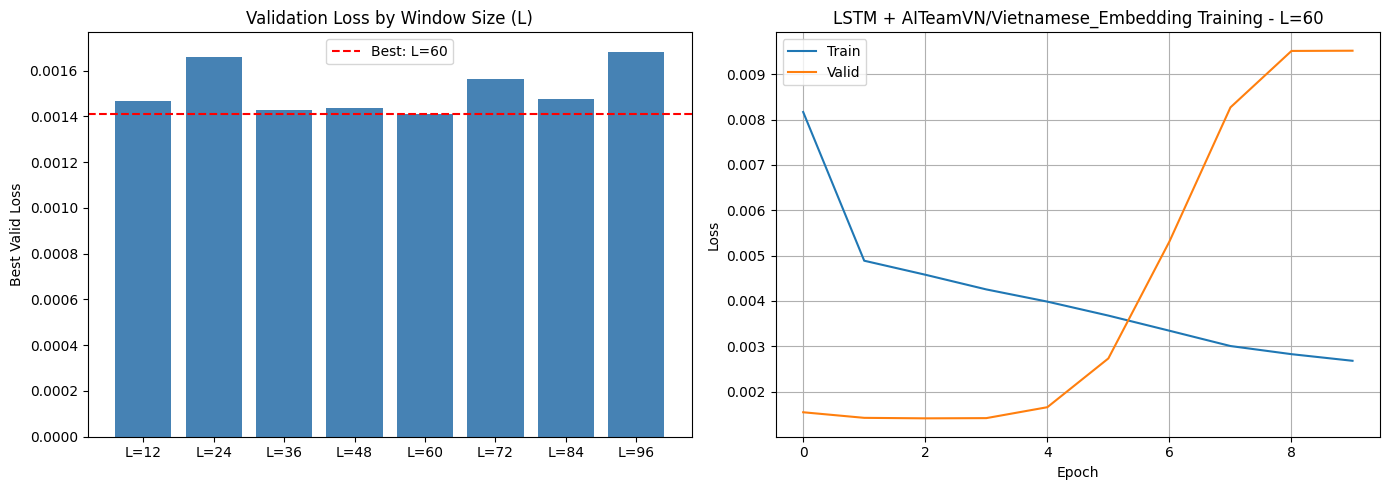

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

axes[0].bar(range(len(L_list)), valid_losses_list, color='steelblue')
axes[0].set_xticks(range(len(L_list)))
axes[0].set_xticklabels([f'L={L}' for L in L_list])
axes[0].set_ylabel('Best Valid Loss')
axes[0].set_title('Validation Loss by Window Size (L)')
axes[0].axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')
axes[0].legend()

# Plot 2: Training curves for best L
if best_L in results_by_L:
    axes[1].plot(results_by_L[best_L]['train_losses'], label='Train')
    axes[1].plot(results_by_L[best_L]['valid_losses'], label='Valid')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'LSTM + AITeamVN/Vietnamese_Embedding Training - L={best_L}')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.show()

##Fusion: concat

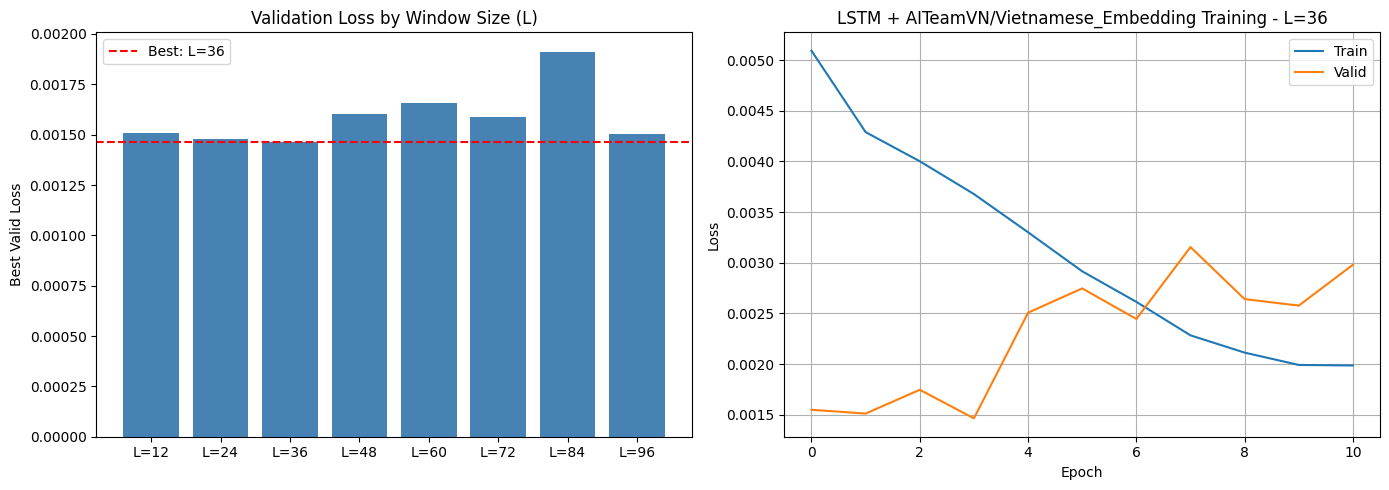

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

axes[0].bar(range(len(L_list)), valid_losses_list, color='steelblue')
axes[0].set_xticks(range(len(L_list)))
axes[0].set_xticklabels([f'L={L}' for L in L_list])
axes[0].set_ylabel('Best Valid Loss')
axes[0].set_title('Validation Loss by Window Size (L)')
axes[0].axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')
axes[0].legend()

# Plot 2: Training curves for best L
if best_L in results_by_L:
    axes[1].plot(results_by_L[best_L]['train_losses'], label='Train')
    axes[1].plot(results_by_L[best_L]['valid_losses'], label='Valid')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'LSTM + AITeamVN/Vietnamese_Embedding Training - L={best_L}')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluation on Test Set

In [ ]:
# Create test dataset
test_dataset = StockMultiDayNewsDataset(
    test_df, test_df_original, feature_cols,
    news_by_date, text_embeddings_cache,
    horizons=H_LIST, window=best_L,
    embedding_dim=EMBEDDING_DIM,
    num_news_days=NEWS_LOOKBACK_DAYS
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test samples: {len(test_dataset)}")

Test samples: 304


In [ ]:
# Load best model
if USE_CROSS_ATTENTION:
    final_model = LSTMCrossAttentionMultiDayNews(
        input_dim=len(feature_cols),
        hidden_dim=32,
        num_layers=3,
        num_horizons=len(H_LIST),
        dropout=0.1,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS,
        num_attention_heads=4,
        use_text=USE_TEXT
    ).to(device)
else:
    final_model = LSTMConcatMultiDayNews(
        input_dim=len(feature_cols),
        hidden_dim=32,
        num_layers=3,
        num_horizons=len(H_LIST),
        dropout=0.1,
        embedding_dim=EMBEDDING_DIM,
        num_news_days=NEWS_LOOKBACK_DAYS,
        text_proj_dim=64,
        use_text=USE_TEXT
    ).to(device)

final_model.load_state_dict(best_model_state)
final_model.eval()
print("Best model loaded")

Best model loaded


In [ ]:
# Evaluate on test set
all_preds = []
all_targets = []
all_base_prices = []
all_actual_prices = []
all_attention_weights = []

with torch.no_grad():
    for X_batch, text_batch, y_batch, base_price_batch, actual_price_batch in test_loader:
        X_batch = X_batch.to(device)
        text_batch = text_batch.to(device)

        if USE_TEXT:
            preds, attn_weights = final_model(X_batch, text_batch)
        else:
            preds, attn_weights = final_model(X_batch)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.numpy())
        all_base_prices.append(base_price_batch.numpy())
        all_actual_prices.append(actual_price_batch.numpy())

        if attn_weights is not None:
            all_attention_weights.append(attn_weights.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_base_prices = np.concatenate(all_base_prices, axis=0)
all_actual_prices = np.concatenate(all_actual_prices, axis=0)

print(f"Predictions shape: {all_preds.shape}")
print(f"Targets shape: {all_targets.shape}")

Predictions shape: (304, 6)
Targets shape: (304, 6)


##Cross-Attention

In [ ]:
print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

for i, h in enumerate(H_LIST):
    pred_returns  = all_preds[:, i]
    actual_returns = all_targets[:, i]

    # Chuyển sang giá
    pred_prices   = all_base_prices * (1 + pred_returns)
    actual_prices = all_actual_prices[:, i]

    # MAE, RMSE, R2 trên PRICE
    mae_price  = mean_absolute_error(actual_prices, pred_prices)
    rmse_price = root_mean_squared_error(actual_prices, pred_prices)
    r2_price   = r2_score(actual_prices, pred_prices)

    # Chuẩn hoá theo giá trung bình (normalized error)
    mean_price = np.mean(actual_prices)
    mae_norm   = mae_price / mean_price
    rmse_norm  = rmse_price / mean_price

    # MAPE trên PRICE
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

    print(
        f"H= {h:>2}: "
        f"MAE={mae_price:,.2f} VND | "
        f"RMSE={rmse_price:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2_price:.5f}"
    )



=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=291.87 VND | RMSE=488.94 VND | MAE_norm=0.01188 | RMSE_norm=0.01990 | MAPE=1.19% | R2=0.91732
H=  4: MAE=538.16 VND | RMSE=886.28 VND | MAE_norm=0.02188 | RMSE_norm=0.03604 | MAPE=2.20% | R2=0.72785
H=  7: MAE=802.04 VND | RMSE=1,168.10 VND | MAE_norm=0.03258 | RMSE_norm=0.04745 | MAPE=3.29% | R2=0.52756
H= 10: MAE=855.49 VND | RMSE=1,283.29 VND | MAE_norm=0.03472 | RMSE_norm=0.05209 | MAPE=3.50% | R2=0.43020
H= 14: MAE=1,213.45 VND | RMSE=1,650.71 VND | MAE_norm=0.04919 | RMSE_norm=0.06692 | MAPE=4.99% | R2=0.07149
H= 21: MAE=1,488.74 VND | RMSE=1,994.33 VND | MAE_norm=0.06024 | RMSE_norm=0.08069 | MAPE=6.16% | R2=-0.31827


pred_prices shape: (280, 6)
all_actual_prices shape: (280, 6)


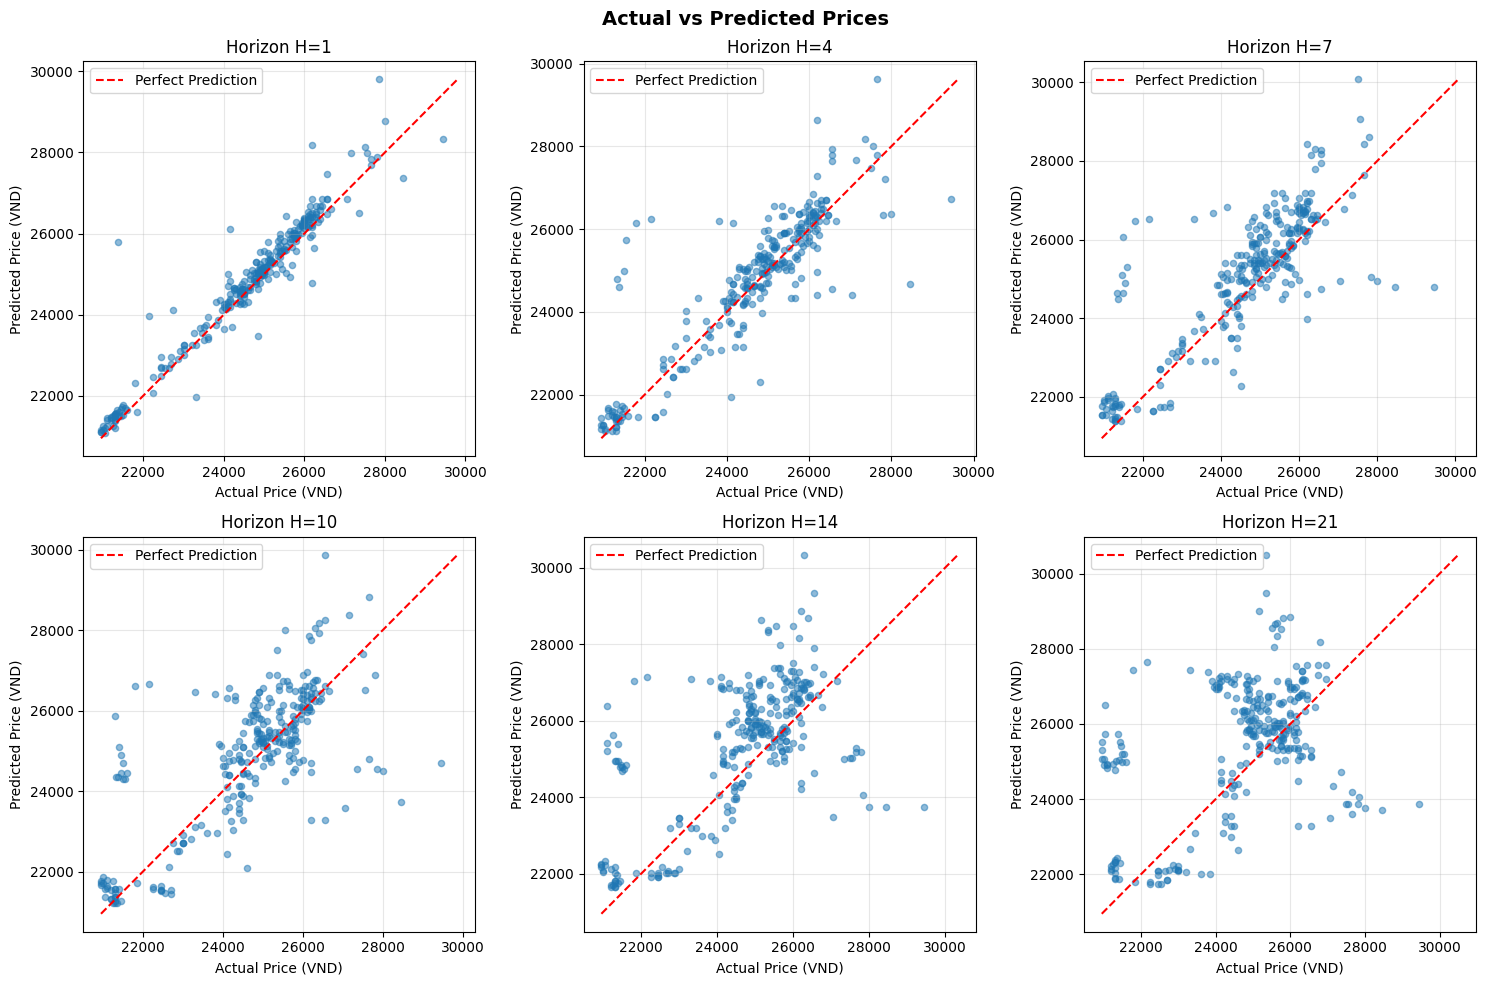

In [ ]:
# Tính pred_prices trước khi plot
pred_prices = np.zeros_like(all_preds)  # [N, 5]
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

# Kiểm tra shape
print(f"pred_prices shape: {pred_prices.shape}")
print(f"all_actual_prices shape: {all_actual_prices.shape}")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

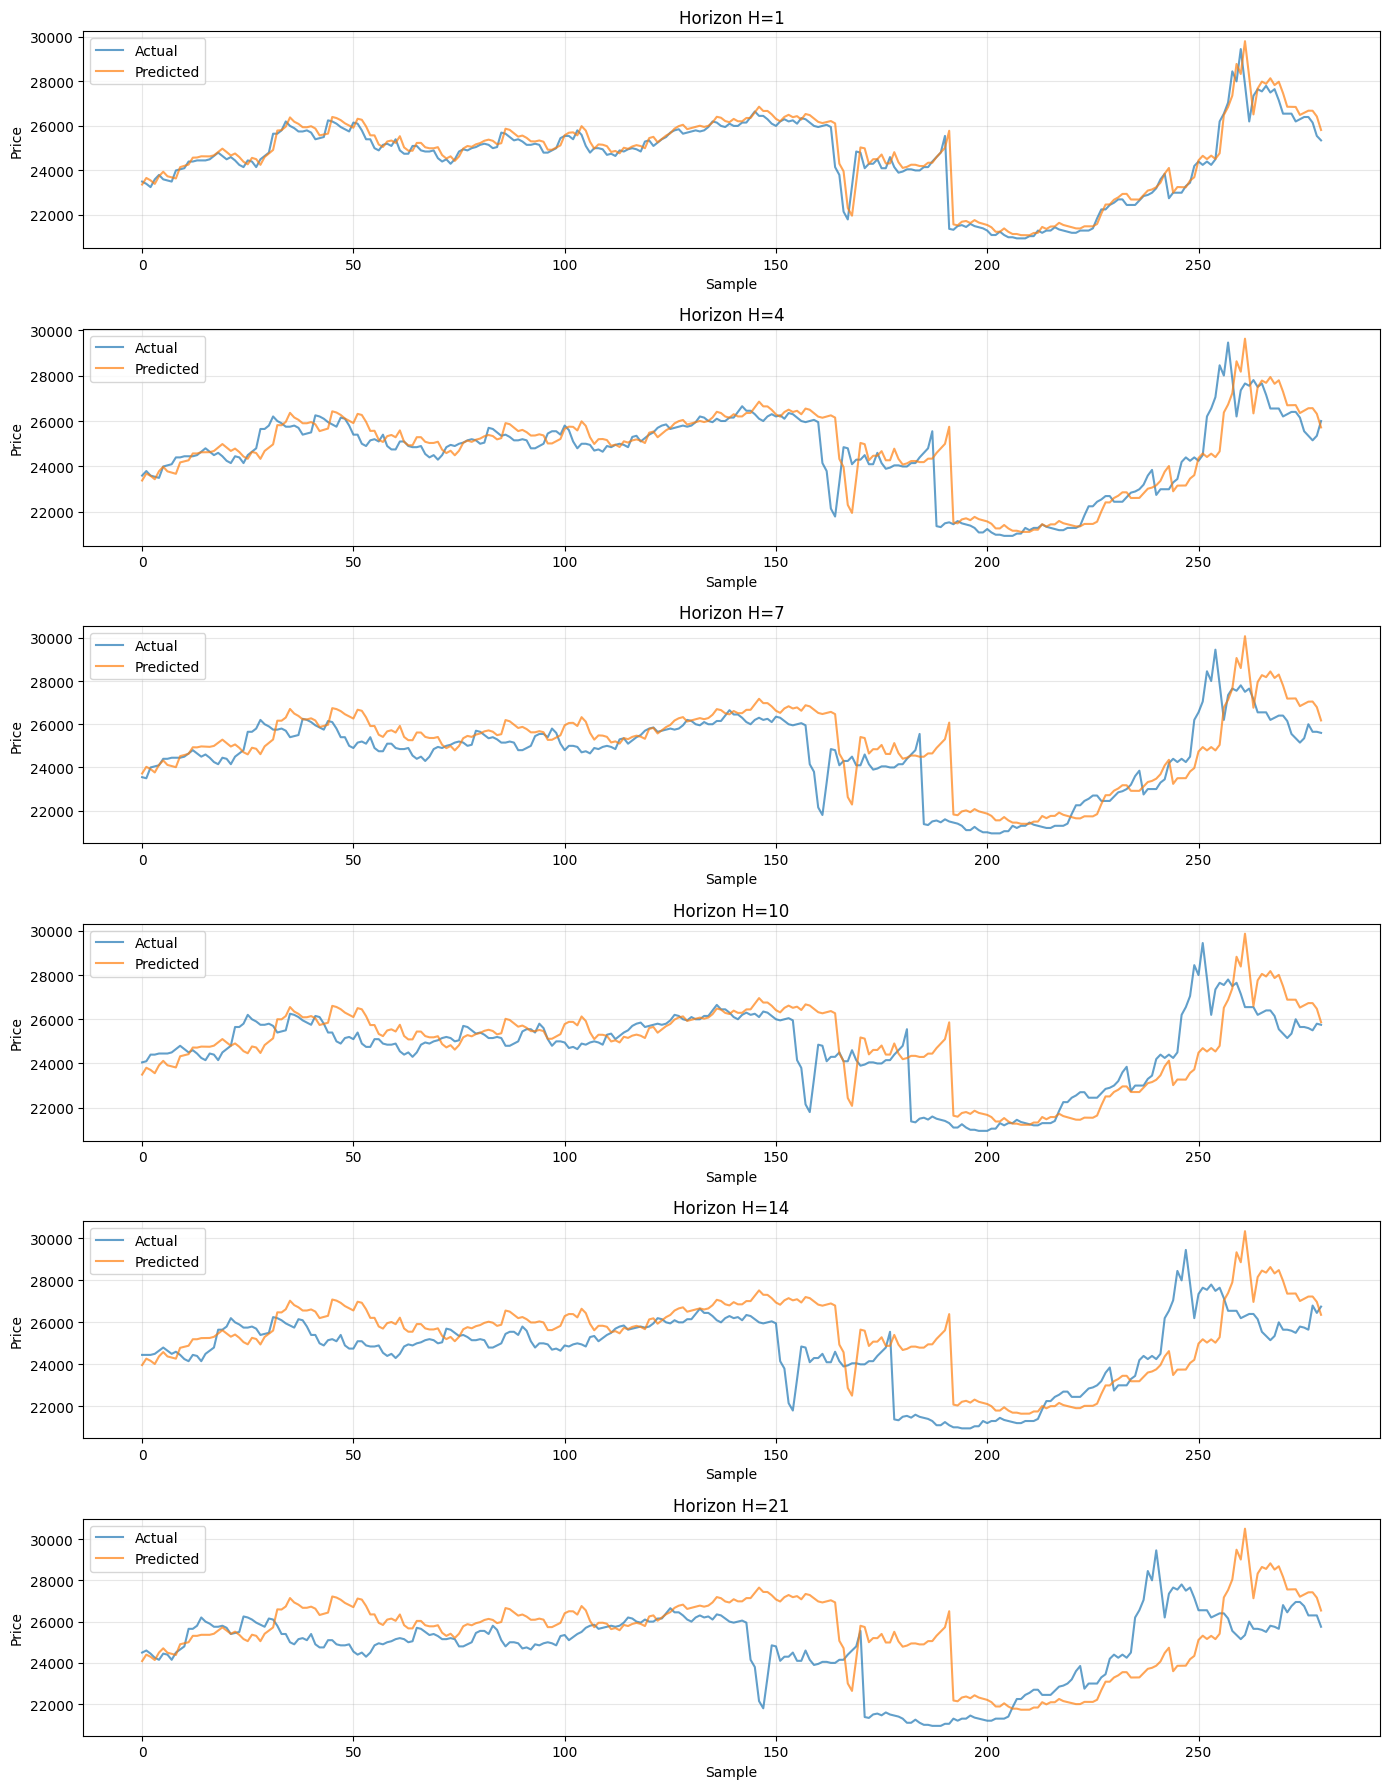

In [ ]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_preds[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##Fusion: concat

In [ ]:
print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

for i, h in enumerate(H_LIST):
    pred_returns  = all_preds[:, i]
    actual_returns = all_targets[:, i]

    # Chuyển sang giá
    pred_prices   = all_base_prices * (1 + pred_returns)
    actual_prices = all_actual_prices[:, i]

    # MAE, RMSE, R2 trên PRICE
    mae_price  = mean_absolute_error(actual_prices, pred_prices)
    rmse_price = root_mean_squared_error(actual_prices, pred_prices)
    r2_price   = r2_score(actual_prices, pred_prices)

    # Chuẩn hoá theo giá trung bình (normalized error)
    mean_price = np.mean(actual_prices)
    mae_norm   = mae_price / mean_price
    rmse_norm  = rmse_price / mean_price

    # MAPE trên PRICE
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

    print(
        f"H= {h:>2}: "
        f"MAE={mae_price:,.2f} VND | "
        f"RMSE={rmse_price:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2_price:.5f}"
    )


=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=420.52 VND | RMSE=551.17 VND | MAE_norm=0.01713 | RMSE_norm=0.02246 | MAPE=1.72% | R2=0.88675
H=  4: MAE=709.27 VND | RMSE=960.62 VND | MAE_norm=0.02888 | RMSE_norm=0.03912 | MAPE=2.89% | R2=0.65715
H=  7: MAE=995.57 VND | RMSE=1,252.25 VND | MAE_norm=0.04052 | RMSE_norm=0.05097 | MAPE=4.04% | R2=0.41964
H= 10: MAE=1,224.68 VND | RMSE=1,497.95 VND | MAE_norm=0.04981 | RMSE_norm=0.06093 | MAPE=4.96% | R2=0.17238
H= 14: MAE=1,464.09 VND | RMSE=1,770.88 VND | MAE_norm=0.05949 | RMSE_norm=0.07196 | MAPE=5.90% | R2=-0.13808
H= 21: MAE=1,868.06 VND | RMSE=2,218.71 VND | MAE_norm=0.07575 | RMSE_norm=0.08997 | MAPE=7.52% | R2=-0.73865


pred_prices shape: (304, 6)
all_actual_prices shape: (304, 6)


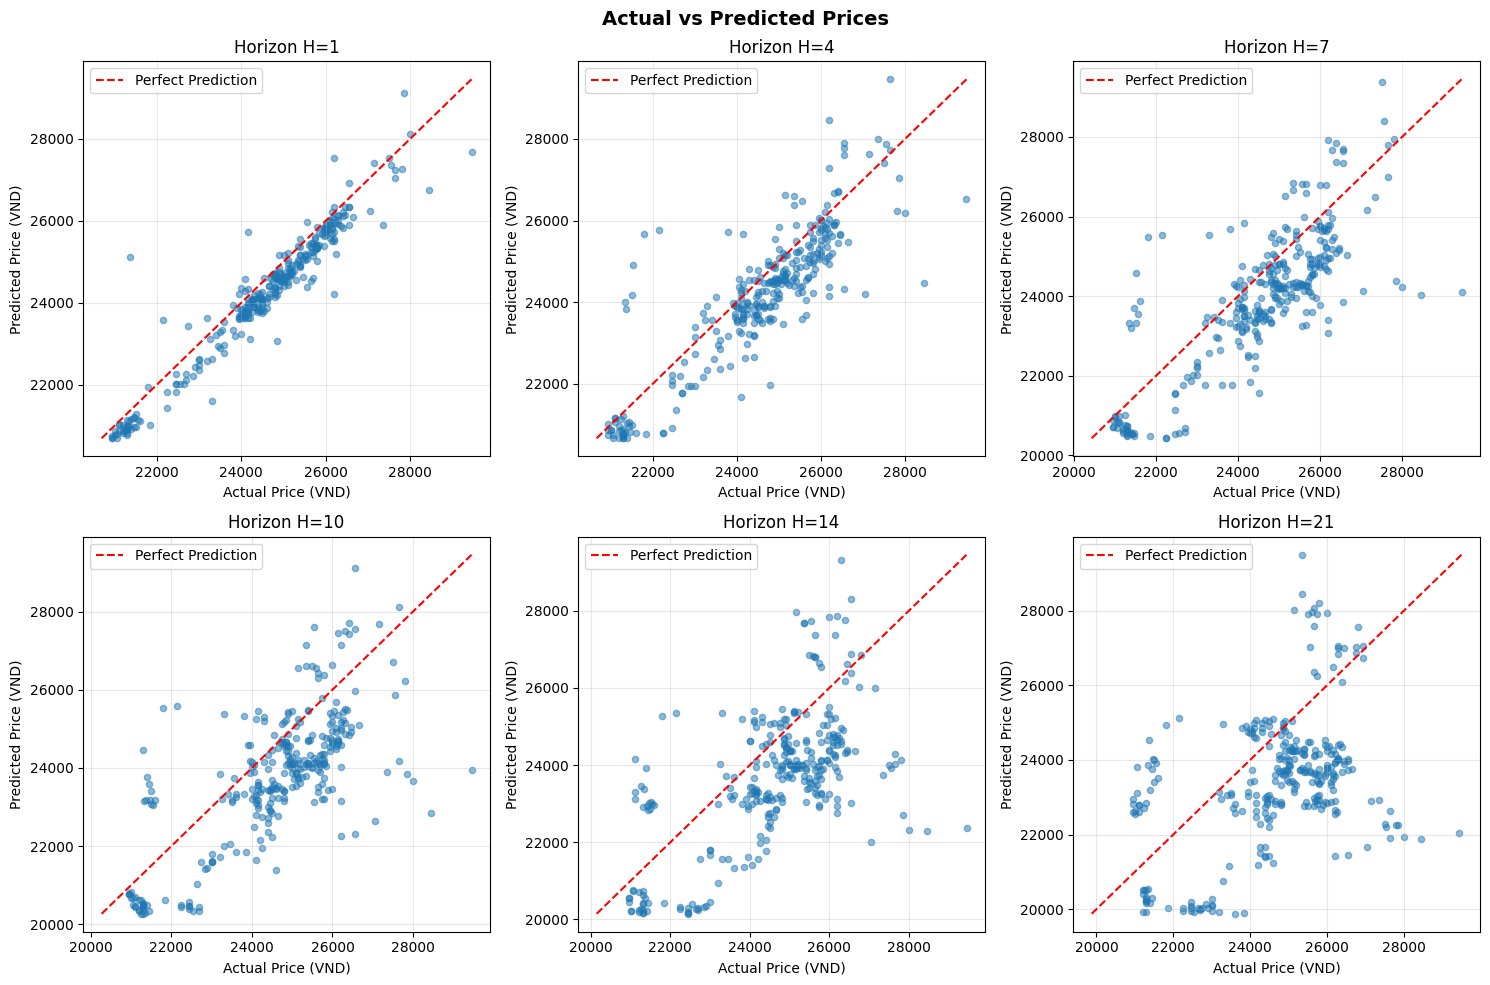

In [ ]:
# Tính pred_prices trước khi plot
pred_prices = np.zeros_like(all_preds)  # [N, 5]
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

# Kiểm tra shape
print(f"pred_prices shape: {pred_prices.shape}")
print(f"all_actual_prices shape: {all_actual_prices.shape}")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

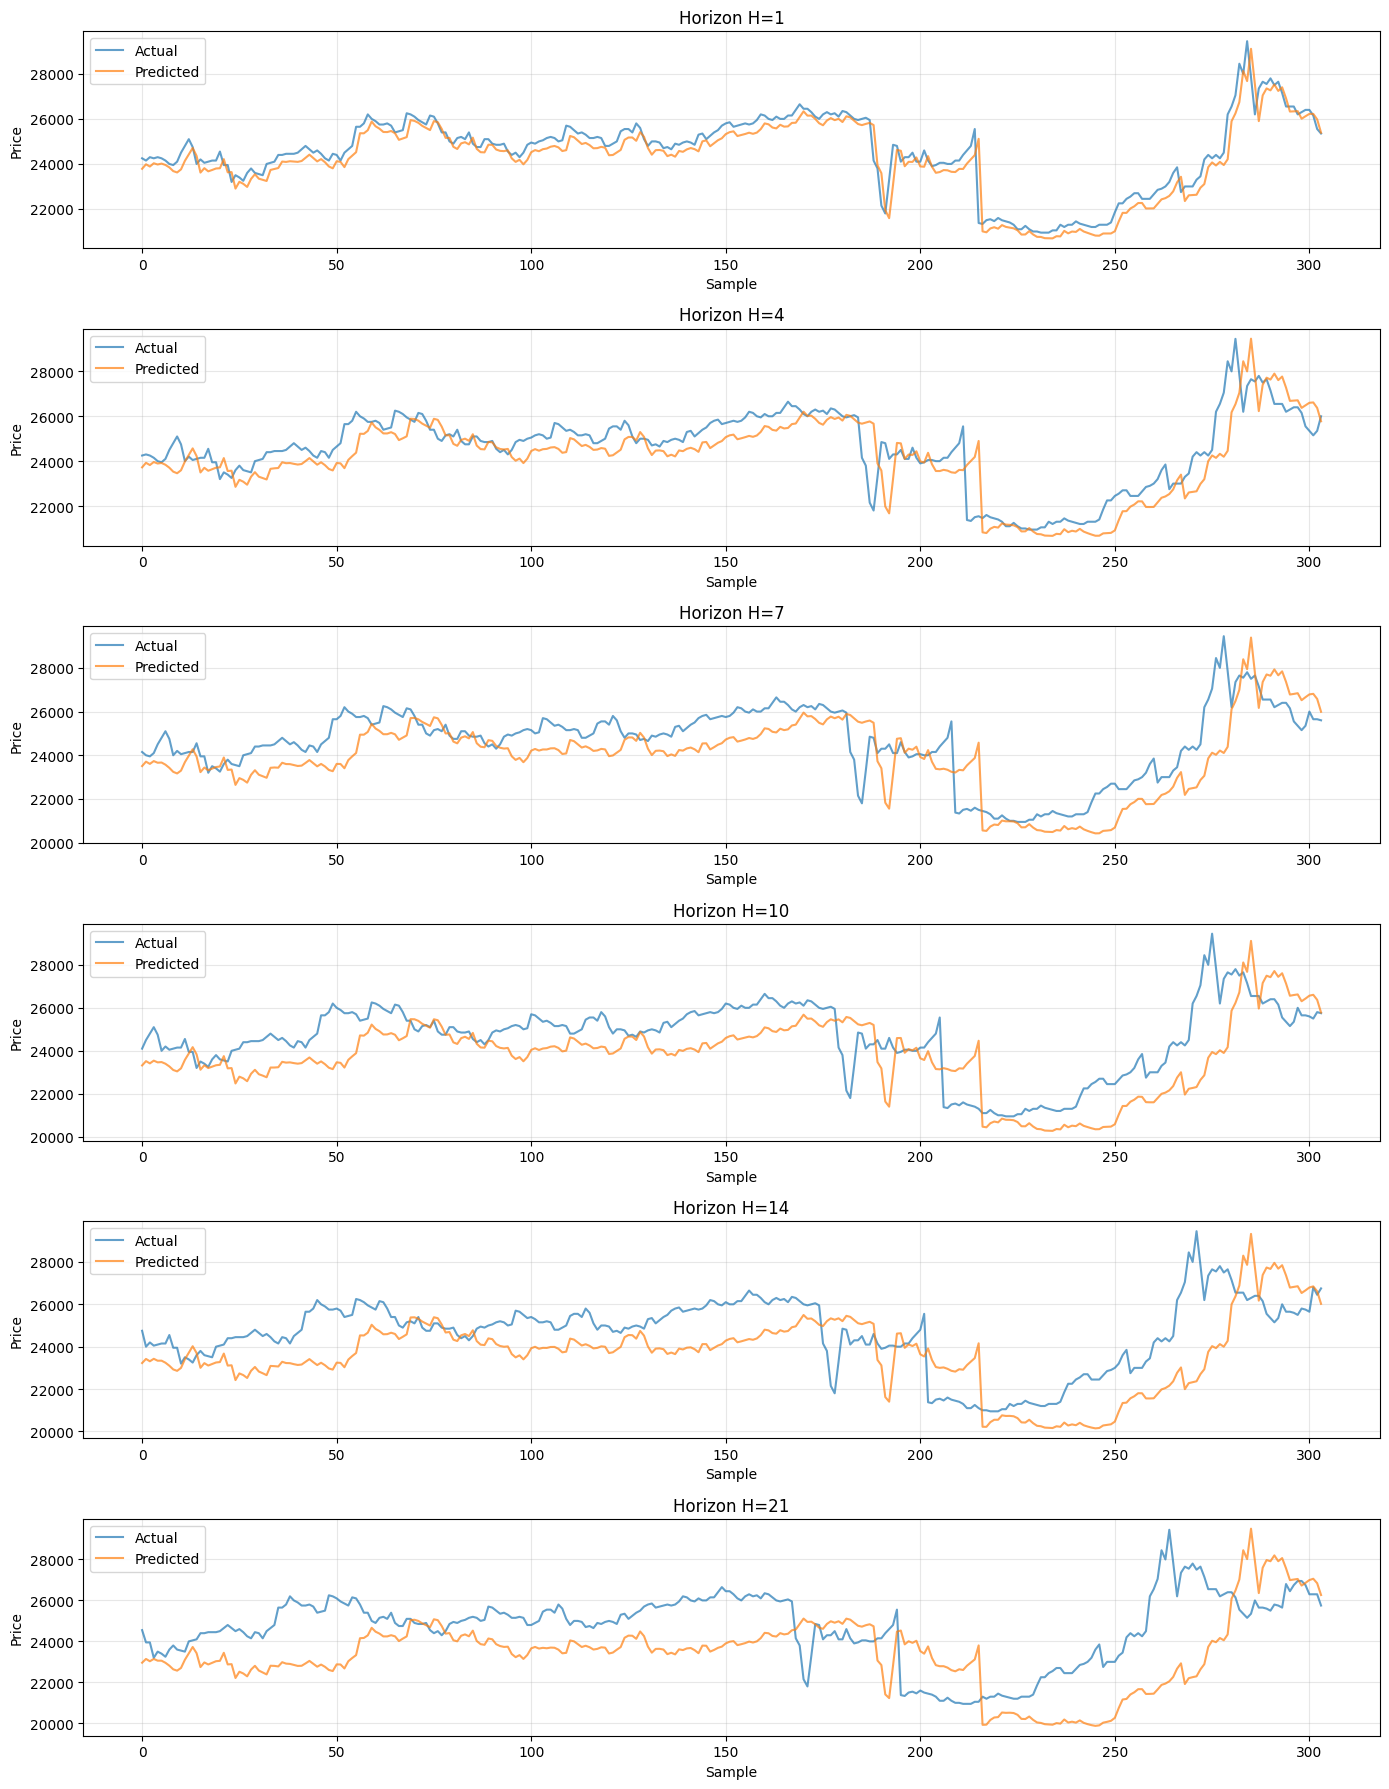

In [ ]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_preds[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#SAMPLE PREDICTIONS

##Cross Attention

In [ ]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        actual_price = all_actual_prices[sample_idx, i]
        pred_pct = all_preds[sample_idx, i]  # Đổi all_y_pred → all_preds

        # Tính giá dự đoán: base + (base * cumulative_return)
        delta = base * pred_pct
        pred_price = base + delta

        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_pct > 0 else "📉"

        print(f"  H={h:3d}: cumulative_return={pred_pct:+.4f} ({pred_pct*100:+.2f}%) {direction}")
        print(f"         Delta={delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>8,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H=  1: cumulative_return=+0.0109 (+1.09%) 📈
         Delta=+287 VND
         Actual=    26,400 VND | Pred=    26,587 VND | Error=     187 VND (0.71%)
  H=  4: cumulative_return=+0.0059 (+0.59%) 📈
         Delta=+156 VND
         Actual=    25,550 VND | Pred=    26,456 VND | Error=     906 VND (3.55%)
  H=  7: cumulative_return=+0.0244 (+2.44%) 📈
         Delta=+641 VND
         Actual=    25,350 VND | Pred=    26,941 VND | Error=   1,591 VND (6.27%)
  H= 10: cumulative_return=+0.0126 (+1.26%) 📈
         Delta=+332 VND
         Actual=    25,650 VND | Pred=    26,632 VND | Error=     982 VND (3.83%)
  H= 14: cumulative_return=+0.0313 (+3.13%) 📈
         Delta=+822 VND
         Actual=    25,750 VND | Pred=    27,122 VND | Error=   1,372 VND (5.33%)
  H= 21: cumulative_return=+0.0384 (+3.84%) 📈
         Delta=+1,011 VND
         Actual=    26,750 VND |

##Fusion: concatenate

In [ ]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        actual_price = all_actual_prices[sample_idx, i]
        pred_pct = all_preds[sample_idx, i]  # Đổi all_y_pred → all_preds

        # Tính giá dự đoán: base + (base * cumulative_return)
        delta = base * pred_pct
        pred_price = base + delta

        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_pct > 0 else "📉"

        print(f"  H={h:3d}: cumulative_return={pred_pct:+.4f} ({pred_pct*100:+.2f}%) {direction}")
        print(f"         Delta={delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>8,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H=  1: cumulative_return=-0.0069 (-0.69%) 📉
         Delta=-182 VND
         Actual=    26,400 VND | Pred=    26,118 VND | Error=     282 VND (1.07%)
  H=  4: cumulative_return=+0.0071 (+0.71%) 📈
         Delta=+188 VND
         Actual=    25,550 VND | Pred=    26,488 VND | Error=     938 VND (3.67%)
  H=  7: cumulative_return=+0.0136 (+1.36%) 📈
         Delta=+358 VND
         Actual=    25,350 VND | Pred=    26,658 VND | Error=   1,308 VND (5.16%)
  H= 10: cumulative_return=+0.0049 (+0.49%) 📈
         Delta=+130 VND
         Actual=    25,650 VND | Pred=    26,430 VND | Error=     780 VND (3.04%)
  H= 14: cumulative_return=+0.0136 (+1.36%) 📈
         Delta=+357 VND
         Actual=    25,750 VND | Pred=    26,657 VND | Error=     907 VND (3.52%)
  H= 21: cumulative_return=+0.0212 (+2.12%) 📈
         Delta=+557 VND
         Actual=    26,750 VND | P

# Save Model

In [ ]:
model_type = "crossattn" if USE_CROSS_ATTENTION else "concat"
text_suffix = "with_text" if USE_TEXT else "no_text"

save_dict = {
    'model_state_dict': best_model_state,
    'best_L': best_L,
    'scaler_robust': scaler_robust,
    'scaler_close': scaler_close,
    'features_robust': features_robust,
    'feature_cols': feature_cols,
    'horizons': H_LIST,
    'use_text': USE_TEXT,
    'use_cross_attention': USE_CROSS_ATTENTION,
    'embedding_model_name': MODEL_NAME,
    'embedding_dim': EMBEDDING_DIM,
    'num_news_days': NEWS_LOOKBACK_DAYS,
    'hidden_dim': 32,
    'num_layers': 3,
    'dropout': 0.1,
    'num_attention_heads': 4 if USE_CROSS_ATTENTION else None
}

model_short_name = MODEL_NAME.split("/")[-1].lower().replace("-", "_")
filename = f'lstm_{model_short_name}_{model_type}_L{best_L}.pth'
torch.save(save_dict, filename)

print(f"\nModel saved as '{filename}'")


Model saved as 'lstm_vietnamese_embedding_concat_L36.pth'


# Comparison: Cross-Attention and Concatenate Normally

To compare, you can:
1. Run the notebook with `USE_ATTENTION = True`
2. Run again with `USE_ATTENTION = False`
3. Compare the metrics